# Import Libray

In [2]:
from live_connection import Live_connection
import threading
import torch
from PIL import Image
from io import BytesIO
import math
import time
import numpy as np
from IPython.display import display,update_display
import ipywidgets as widgets

# Setup stuffs

## Load and setup model

In [3]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5x6', pretrained=True)
model.classes = [0,59,63,67]# person, bed, laptop(as some phone can be detact by laptop), cell phone 
torch.set_num_interop_threads(8)# improve performance
torch.set_num_threads(8)

Using cache found in C:\Users\Tommy AU/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-1 Python-3.10.9 torch-1.12.1 CPU

Fusing layers... 
YOLOv5x6 summary: 574 layers, 140730220 parameters, 0 gradients
Adding AutoShape... 


## 🚩 Here is the place to start the program
## Start and Setup socket(Connect camera) 
## And Call main()
<br>

> #### ⚠  There maybe exeption message pop up when you restart the socket, ignore it will do the job<br>But if it this error from system os it is recommend to use another port


> #### ⚠  There maybe error message pop up when you restart the socket, ignore it will do the job<br>
>This error<br>
Exception in thread Thread-7 (start_recieve):<br>
Traceback (most recent call last):<br>
(some message has been hidden for privacy reason)<br>
    frameid = splited[1]<br>
IndexError: list index out of range<br>
    frameid = splited[1]<br>
IndexError: list index out of range<br>

> #### "WARNING NMS time limit 0.550s exceeded" can be ignore

> #### 🎥 The image will have a high latency then the actuall latency,<br>   As the render of image use >10 sec.<br>Stuff is still working on normal latency, only the image preview is slow.

> #### ⚠  Print message may disappear quick, as it seems that it may be clean when the thread of its is stop.

> #### ⚠  If none of the above work try to restart kernel or even restart pc

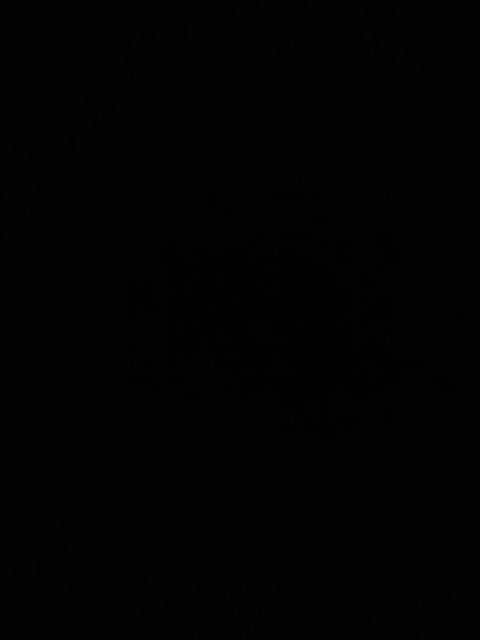

Button(description='Stop', style=ButtonStyle())

Exception in thread Thread-327 (start_recieve):
Traceback (most recent call last):
  File "c:\Users\Tommy AU\.conda\envs\myenv\lib\threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-328 (start_recieve):
Traceback (most recent call last):
  File "c:\Users\Tommy AU\.conda\envs\myenv\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\Tommy AU\.conda\envs\myenv\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "d:\my programs\python\Aiot\aiot_bedroom\ai_analysis\live_connection.py", line 84, in start_recieve
    frameid = splited[1]
IndexError: list index out of range
    self.run()
  File "c:\Users\Tommy AU\.conda\envs\myenv\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "d:\my programs\python\Aiot\aiot_bedroom\ai_analysis\live_connection.py", line 84, in start_recieve
    frameid = splited[1]
IndexError: list index out of range


In [29]:
addr = "192.168.0.210"## use ipconfig to find the ip address of the computer
x = input("Address to bind(enter for default):")
if x != "":
    addr = x
try:
    if live_connection != None and not live_connection.died:
        live_connection.terminate()
except NameError:
    pass
live_connection = None
live_connection = Live_connection(addr,7790)# 7777 is the default port, use other port if the port is blocked

t1 = threading.Thread(target=live_connection.start_connection,kwargs={"nolog":True},group=None)
# nolog = True
t1.start()
term = True
button_download = widgets.Button(description = 'Stop')   
button_download.on_click(onclick)
display(button_download)
main_analysis()

### Force Stop
> Press start and stop the below cell multiple times to kill the program

In [4]:
def onclick(arg):
    Term = False
    live_connection.terminate()
    t1.terminate()
    live_connection = None

### Close socket if needed
> or reset some var

In [5]:
# live_connection.ss.close()
# live_connection = None

## Variable of current state

In [6]:
#global tolerance
tolerance = 10
## Person exist
personexist = False
## lying bed
lyingonbed = False
startlyingtime = 0
notlyingtimestart = 0
chancelying = 3
## touching phone
Touchingphone = False
starttouchingtime = 0
nottouchingtimestart = 0
chanceTouching = 3
## sleeping
sleeping = False
startsleepingtime = 0
notsleepingtimestart = 0
## not moving
notmoving = False
lastposition = [0,0,0,0]
toleranceOfNotMoving = 10
startnotmovingtime = 0
movingtimestart = 0
chancenotmoving = 2
## temperatures
tempPerson = []
### core temp requires face recongnition
tempBed = 0

# Condition for automation

## Person detection

In [7]:
def isPersonAvailable(pandas)-> bool:
    return 0 in pandas['class'].array

## Bed lying detection

In [8]:
def isLyinOnBed(pandas,k:int)->bool:
    #pandasDataFrame is the output of model(pandas.DataFrame)
    #return true if the person is lying on the bed
    #return false if the person is not lying on the bed

    # Check if the person is on bed     
    if not(0 in pandas['class'].array):
        return False
    # Calculate the length ratio of person on the bed
    personxlen = pandas[pandas['class'] == 0]['xmax'].array[k] - pandas[pandas['class'] == 0]['xmin'].array[k]
    personylen = pandas[pandas['class'] == 0]['ymax'].array[k] - pandas[pandas['class'] == 0]['ymin'].array[k]
    if not(59 in pandas['class'].array):
        if personylen>personxlen:
            if(personylen/personxlen>3 and personylen/personxlen<5):# acoording to web data, the ratio of length of shoulder is 4:1
                return True
            else:
                return False
    bedxlen = pandas[pandas['class'] == 59]['xmax'].array[0] - pandas[pandas['class'] == 59]['xmin'].array[0]
    bedylen = pandas[pandas['class'] == 59]['ymax'].array[0] - pandas[pandas['class'] == 59]['ymin'].array[0]

    if bedxlen > bedylen :
            return personxlen/bedxlen > 0.7
    else:
            return personylen/bedylen > 0.7


## Touching phone detection

In [9]:
def isTouchingPhone(pandas,person)->bool:
    #pandasDataFrame is the output of model(pandas.DataFrame)
    #return true if the person is touching the phone
    #return false if the person is not touching the phone
    #return None if the person is not in the frame
    # Check if the person is on bed
    phone = []
    if not(63 in pandas['class'].array):
        return False
    else:
        phone.append(pandas[pandas['class'] == 63])
    if not(67 in pandas['class'].array):
        return False
    else:
        phone.append(pandas[pandas['class'] == 67])
    person = pandas[pandas['class'] == 0]
    # see if the person touches the phone
    overlapArea = 0
    for x in person:
        for y in phone:
            for z in range(len(y)):
                x_overlap = math.max(0, math.min(y['xmax'].array[z], person['xmax'].array[x]) - math.max(y['xmin'].array[z], person['xmin'].array[x]));
                y_overlap = math.max(0, math.min(y['ymax'].array[z], person['ymax'].array[x]) - math.max(y['ymin'].array[z], person['ymin'].array[x]));
                overlapArea = math.Max(overlapArea,x_overlap * y_overlap);
                areaphone = (y['xmax'].array[z] - y['xmin'].array[z])*(y['ymax'].array[z] - y['ymin'].array[z])
                if overlapArea/areaphone > 0.5:
                    return True
    return False

## Human movement detection

In [10]:
def isnotmoving(pandas)->bool:
    #pandasDataFrame is the output of model(pandas.DataFrame)
    #return true if the person is not moving
    #return false if the person is moving
    #return None if the person is not in the frame
    # Check if the person is on bed
    person = pandas[pandas['class'] == 0]
    if len(person) == 0:
        return None
    else:
        x = person['xmin'].array[0]
        y = person['ymin'].array[0]
        x2 = person['xmax'].array[0]
        y2 = person['ymax'].array[0]
        if abs(x - lastposition[0]) < toleranceOfNotMoving and abs(y - lastposition[1]) < toleranceOfNotMoving and abs(x2 - lastposition[2]) < toleranceOfNotMoving and abs(y2 - lastposition[3]) < toleranceOfNotMoving:
            return True
        else:
            lastposition[0] = x
            lastposition[1] = y
            lastposition[2] = x2
            lastposition[3] = y2
            return False

## Bed Temperature

In [11]:
def insideBed(x,y,pandas):
    return x > pandas[pandas['class'] == 59]['xmin'].array[0] and x < pandas[pandas['class'] == 59]['xmax'].array[0] and y > pandas[pandas['class'] == 59]['ymin'].array[0] and y < pandas[pandas['class'] == 59]['ymax'].array[0]
def insideOtherObject(x,y,pandas):
    list = pandas[pandas['class']!=59]
    for i in range(len(list)):
        if x > list['xmin'].array[i] and x < list['xmax'].array[i] and y > list['ymin'].array[i] and y < list['ymax'].array[i]:
            return True
    return False
def bedtemperature(pandas,thermal):
    ## calculate the temperature of the bed by calculate the average temperature of the bed exclude the person
    ## return the temperature of the bed
    if(59 not in pandas['class'].array):
        return None
    temp = 0
    count = 0
    for x in range(len(thermal[0])):
        for y in range(len(thermal)):
            # exclude persons and the extra objects
            # only count the temperature of the bed
            if insideBed(x,y,pandas) and not insideOtherObject(x,y,pandas):
                count+=1
                temp = temp + (thermal[y][x] - temp)/count
    return temp 

## Body Temperature

In [12]:
def bodytemperture(pandas,thermal,k:int):
    ## calculate the temperature of the person by calculate the average temperature of the person
    ## return the temperature of the person
    ## reduce the insignificant temperature(extermely low or high,ie >40, <20)
    temp = 0
    count = 0
    for x in range(len(thermal[0])):
        for y in range(len(thermal)):
            ## check if the point is in the person
            if ( pandas[pandas['class'] == 0]['xmax'].array[k] <= x and np.all(x >= pandas[pandas['class'] == 0]['xmin'].array[k] ) \
            and                                                                                                                     \
                pandas[pandas['class'] == 0]['ymax'].array[k] <= x and np.all(x >= pandas[pandas['class'] == 0]['ymin'].array[k] ) )\
            and thermal[x][y] < 40 and thermal[x][y] > 20:
                 count+=1
                 temp = temp + (thermal[x][y] - temp)/count
    return temp

## Detection Main

In [13]:
## touching phone
def detecttouch(pandas,person,timenow):
    global nottouchingtimestart,starttouchingtime,Touchingphone,chanceTouching
    if isTouchingPhone(pandas,person):
        chanceTouching = 0
        if not Touchingphone:
            Touchingphone = True
            starttouchingtime = timenow
            nottouchingtimestart = 0
            print("Touching phone")
    else:
        if Touchingphone:
            chanceTouching += 1
            if chanceTouching > 3:
                nottouchingtimestart = timenow
                Touchingphone = False
                print("Touching phone for",timenow-starttouchingtime,"seconds")
                starttouchingtime = 0

## is not moving
def detectmoving(pandas,person,timenow):
    global notmoving,startnotmovingtime,movingtimestart,chancenotmoving
    if isnotmoving(pandas):
        chancenotmoving = 0
        if not notmoving:
            notmoving = True
            startnotmovingtime = timenow
            movingtimestart = 0
            print("Not moving")
    else:
        if notmoving:
            chancenotmoving += 1
            if chancenotmoving > 2:
                movingtimestart = timenow
                notmoving = False
                print("Not moving for",timenow-startnotmovingtime,"seconds")
                startnotmovingtime = 0
    ### sleeping or in sleep mood
# if lyingfor bed for 10 seconds and not touching phone for 10 seconds, then sleep 
def detectsleep(pandas,person,timenow):  
    global sleeping,startsleepingtime,notsleepingtimestart 
    if lyingonbed and not Touchingphone:
        if not sleeping:
            startsleepingtime = timenow
            sleeping = True
            notsleepingtimestart = 0
            print("Sleeping")
    else:# no need tolerance as thee is already tolerance in lying on bed and touching phone
        if sleeping:
            print("Sleeping for",timenow-startsleepingtime,"seconds")
            startsleepingtime = 0
            sleeping = False
            notsleepingtimestart = timenow
## calculate the temperature of the bed
def detecttemperature(pandas,thermal,person):
    tempBed = bedtemperature(pandas,thermal)
    if lyingonbed:
        tempPerson = [bodytemperture(pandas,thermal,k) for k in person] 

def detections(pandas,thermal,timenow):
    noperson = len(pandas[pandas['class'] == 0])
    if(isPersonAvailable(pandas)):
            personexist = True
            pass # can add time automation
    else:
        personexist = False
        pass # can add time automation

    ## lying on bed
    re = False
    person = []
    global lyingonbed,notlyingtimestart,startlyingtime,chancelying
    for k in range(noperson):
        if(isLyinOnBed(pandas,k)):
            re = True
            person.append(k)
    if re:
        chancelying = 0
        if not lyingonbed:
            lyingonbed = True
            startlyingtime = timenow
            notlyingtimestart = 0
    else:
        if lyingonbed:
            chancelying += 1
            if chancelying > 3:
                notlyingtimestart = timenow
                lyingonbed = False
                print("Lying on bed for",timenow-startlyingtime,"seconds")
                startlyingtime = 0
    
    t1 = threading.Thread(target=detecttouch,args=(pandas,person,timenow))
    t2 = threading.Thread(target=detectmoving,args=(pandas,person,timenow))
    t3 = threading.Thread(target=detectsleep,args=(pandas,person,timenow))
    t4 = threading.Thread(target=detecttemperature,args=(pandas,thermal,person))
    t1.start()
    t2.start()
    t3.start()
    t4.start()


            

# Actions

> All action are customizable, are highly extensible

In [14]:
#dummy variable for example
playingmusic = False 
lights = False 
aircon = False
aircontemp = 25
lastairconchange = 0
callambulance = False

## When lying on bed

In [15]:
def OnLyingBed(lying:bool,startlyingtime:float,stoplyingtime:float):
    # Here are some examples
    ## if the person is lying on the bed for more than 5 seconds, play music
    global playingmusic,aircon
    if lying and time.time()-startlyingtime >5 and not playingmusic:
        #play music
        playingmusic = True
        print("playing music")
    elif lying and stoplyingtime-time.time() >5 and playingmusic:
        #stop music
        playingmusic = False
        print("stop music")
    
    ## air con control
    if lying and time.time()-startlyingtime >10 and not aircon:
        #play music
        aircon = True
        print("Aircon on")
    elif lying and stoplyingtime-time.time() >30 and aircon:
        #stop music
        playingmusic = False
        print("Aircon off")


## When using(touching) phone

In [16]:
def OnTouchingPhone(touching:bool,starttouchingtime:float,stoptouchingtime:float):
    # Here are some examples
    ## if the person is touching the phone for more than 15 seconds, turn on the lights
    global lights
    if touching and time.time() - starttouchingtime >15 and not lights:
        #turn on lights
        lights = True
        print("turn on lights")

## When sleeping(on sleep mood)

In [17]:
def OnSleeping(sleeping:bool,startsleepingtime:float,stopsleepingtime:float):
    # Here are some examples
    ## if the person is in sleep mood for 5 seconds, turn off the lights
    global light,playmusic
    if sleeping and startsleepingtime-time.time() >5 and lights:
        #turn off lights
        lights = False
        playmusic = False
        print("turn off lights")
        print("stop music")
    ## air con control

## When not moving/moving

In [18]:
def OnNotMoving(notmoving:bool,startnotmovingtime:float,stopnotmovingtime:float,haveperson:bool):
    # Here are some examples
    ## if person is not lying on bed and not moving for 20 seconds, call for the ambulance
    global lyingonbed
    if notmoving and startnotmovingtime-time.time() >20 and not lyingonbed and haveperson:
        #call for ambulance
        callambulance = True
        print("call for ambulance")

## Temperature handle

In [19]:
countOfDangerTemp = 0
def OnTemperature(tempPerson:list[float],tempBed):
    # Here are some examples
    ## if temperature of the person is more than 40 degrees or lower than 30 degrees, call for the ambulance
    global callambulance,countOfDangerTemp,aircon,aircontemp,lastairconchange
    if  len(tempPerson) > 0 and (max(tempPerson) > 40 or min(tempPerson) < 30):
        countOfDangerTemp +=1
        if countOfDangerTemp > 5:
            #call for ambulance
            callambulance = True
            print("call for ambulance")
    else:
        countOfDangerTemp = 0
    # ideal bed temp is betweeen 27 - 31
    # body temp is 36
    timenow = time.time()
    if len(tempPerson) > 0 and tempBed < 27:
        if not aircon:
            aircon = True
            print("Aircon on")

        if lastairconchange - timenow > 300:#i.e. 5min
            aircontemp +=1
            lastairconchange = timenow
    elif len(tempPerson) > 0 and tempBed  > 31:
        if not aircon:
            aircon = True
            print("Aircon on")

        if lastairconchange - timenow > 300:#i.e. 5min
            aircontemp +=1
            lastairconchange = timenow
            



## Add more if you like

In [20]:
## Action main
def actions():
    t1 = threading.Thread(target=OnLyingBed,args=(lyingonbed,startlyingtime,notlyingtimestart))
    t2 = threading.Thread(target=OnTouchingPhone,args=(Touchingphone,starttouchingtime,nottouchingtimestart))
    t3 = threading.Thread(target=OnSleeping,args=(sleeping,startsleepingtime,notsleepingtimestart))
    t4 = threading.Thread(target=OnNotMoving,args=(notmoving,startnotmovingtime,movingtimestart,personexist))
    t5 = threading.Thread(target=OnTemperature,args=(tempPerson,tempBed))
    ## Add more if you like
    t1.start()
    t2.start()
    t3.start()
    t4.start()
    t5.start()
    

# Main

In [26]:
def main_analysis():
    print("Main starts")
    imagedisplay = widgets.Image(width=480, height=640)
    display(imagedisplay,display_id="1")
    while term:
        #get data
        if live_connection.new_frame_avaliable:
            (frame,thermaldata)= live_connection.getcurrentframe()
            
            ## get into threading
            t2 = threading.Thread(target=worker,args=(frame,thermaldata))
            t2.start()



        def worker(frame,thermaldata):
            ## convert bytes to image
            timenow = time.time()
            image = Image.open(BytesIO(frame))
            ## make prediction
            results = model(image)
            ## display the image
            t3 = threading.Thread(target=SetDisplay,args=(results,))
            t3.start()
            ## get the result
            pandas = results.pandas().xyxy[0]
            # DETECTIONS
            detections(pandas,thermaldata,timenow)
            # ACTIONS
            actions()
            
        def SetDisplay(results):
            results.render()
            update_display(Image.fromarray(results.ims[0]),display_id="1")
            display(button_download)

            